In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

## Create necessary classes and functions

Create class to handle "cities"

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

Create a fitness function

In [61]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0

    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        print('distance : ', self.distance)
        return self.distance

    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        #print(self.fitness)
        return self.fitness

## Create our initial population

Route generator

In [19]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    #print('route',route)
    return route

Create first "population" (list of routes)

In [30]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))

    print('population')
    for i in range(len(population)):
        print(i,population[i])
    return population

## Create the genetic algorithm

Rank individuals

In [63]:
def rankRoutes(population):
    fitnessResults = {}
    print('Fitness')
    for i in range(0,len(population)):
        print(i)
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Create a selection function that will be used to make the list of parent routes

In [7]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [8]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [9]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Create function to run crossover over full mating pool

In [48]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize

    pool = random.sample(matingpool, len(matingpool))

    #menyimpan individu dengan nilai terbaik sebesar eliteSize
    for i in range(0,eliteSize):
        children.append(matingpool[i])

    #crossover
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Create function to mutate a single route

In [11]:
#mutasi tiap individu
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [49]:
#mutasi untuk 1 populasi
def mutatePopulation(population, mutationRate):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [46]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)

    print('\npopRanked')
    for i in range(len(popRanked)):
        print(i,popRanked[i])

    selectionResults = selection(popRanked, eliteSize)

    print('\nselectionResults')
    for i in range(len(selectionResults)):
        print(i,selectionResults[i])

    matingpool = matingPool(currentGen, selectionResults)

    print('\nmatingpool')
    for i in range(len(matingpool)):
        print(i,matingpool[i])

    children = breedPopulation(matingpool, eliteSize)

    print('children')
    for i in range(len(children)):
      print(i,children[i])

    nextGeneration = mutatePopulation(children, mutationRate)

    print('nextGeneration')
    for i in range(len(nextGeneration)):
      print(i,nextGeneration[i])

    return nextGeneration

Final step: create the genetic algorithm

In [58]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))

    for i in range(0, generations):
        print("\n----GENERATION", i)
        pop = nextGeneration(pop, eliteSize, mutationRate)

    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Running the genetic algorithm

Create list of cities

In [37]:
cityList = []

for i in range(0,5):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

for i in range(len(cityList)):
    print(i, cityList[i])

0 (150,133)
1 (186,0)
2 (61,125)
3 (173,139)
4 (175,9)


Run the genetic algorithm

In [64]:
geneticAlgorithm(population=cityList, popSize=5, eliteSize=2, mutationRate=0.01, generations=2)

population
0 [(175,9), (150,133), (186,0), (173,139), (61,125)]
1 [(186,0), (61,125), (150,133), (173,139), (175,9)]
2 [(150,133), (175,9), (186,0), (173,139), (61,125)]
3 [(61,125), (150,133), (186,0), (173,139), (175,9)]
4 [(175,9), (173,139), (61,125), (186,0), (150,133)]
Fitness
0
distance :  679.4000321407998
1
distance :  434.1333052614187
2
distance :  482.5447553821711
3
distance :  659.4075753857915
4
distance :  683.9448127289709
Initial distance: 434.1333052614187

----GENERATION 0
Fitness
0
distance :  679.4000321407998
1
distance :  434.1333052614187
2
distance :  482.5447553821711
3
distance :  659.4075753857915
4
distance :  683.9448127289709

popRanked
0 (1, 0.0023034399523847583)
1 (2, 0.0020723466348898747)
2 (3, 0.001516512756795283)
3 (0, 0.0014718868894500708)
4 (4, 0.0014621062714255475)

selectionResults
0 1
1 2
2 2
3 1
4 3

matingpool
0 [(186,0), (61,125), (150,133), (173,139), (175,9)]
1 [(150,133), (175,9), (186,0), (173,139), (61,125)]
2 [(150,133), (175,9), 

[(186,0), (61,125), (150,133), (173,139), (175,9)]

## Plot the progress

Note, this will win run a separate GA

In [50]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])

    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

Run the function with our assumptions to see how distance has improved in each generation

Output streaming akan dipotong hingga 5000 baris terakhir.
2
distance :  429.58852467324755
3
distance :  454.125762016427
4
distance :  429.58852467324755

popRanked
0 (0, 0.002327808920782084)
1 (1, 0.002327808920782084)
2 (2, 0.002327808920782084)
3 (4, 0.002327808920782084)
4 (3, 0.0022020331891319284)

selectionResults
0 0
1 1
2 3
3 4
4 3

matingpool
0 [(61,125), (175,9), (186,0), (173,139), (150,133)]
1 [(61,125), (175,9), (186,0), (173,139), (150,133)]
2 [(175,9), (186,0), (61,125), (173,139), (150,133)]
3 [(61,125), (175,9), (186,0), (173,139), (150,133)]
4 [(175,9), (186,0), (61,125), (173,139), (150,133)]
children
0 [(61,125), (175,9), (186,0), (173,139), (150,133)]
1 [(61,125), (175,9), (186,0), (173,139), (150,133)]
2 [(173,139), (61,125), (175,9), (186,0), (150,133)]
3 [(175,9), (186,0), (61,125), (173,139), (150,133)]
4 [(175,9), (186,0), (61,125), (173,139), (150,133)]
nextGeneration
0 [(61,125), (175,9), (186,0), (173,139), (150,133)]
1 [(61,125), (175,9), (186,0), (173

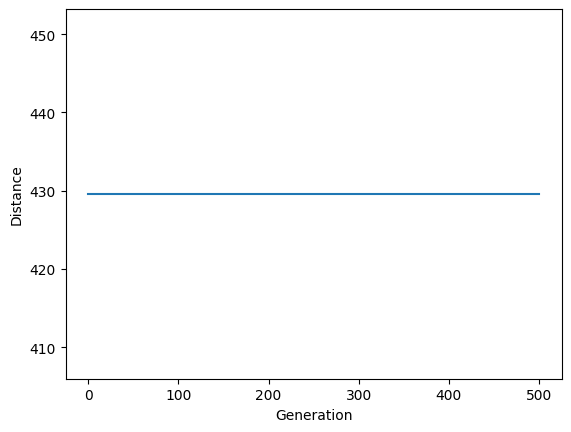

In [65]:
geneticAlgorithmPlot(population=cityList, popSize=5, eliteSize=2, mutationRate=0.01, generations=500)